In [34]:
from google.colab import drive
drive.mount('./gdrive')

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


In [5]:
! pip install razdel
! pip install tqdm
! pip install nltk

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 1.5MB 10.8MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449903 sha256=7e5f1b4ce68eb6396a7397aaa1f445232202415f5ad53a5992f5f34e00fec86d
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
import csv
import string
from collections import defaultdict
from tqdm import tnrange, tqdm_notebook
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import re
import pandas as pd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import nltk
from razdel import sentenize
from nltk.corpus import stopwords
import string
from nltk.tokenize import wordpunct_tokenize as tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine

In [8]:
SEED = 1
torch.manual_seed(SEED)
np.random.seed(SEED)

In [7]:
# Russian NLP utilites
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
stemmer = nltk.stem.snowball.SnowballStemmer("russian")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
DEVICE = torch.device('cuda' 
                      if torch.cuda.is_available() 
                      else 'cpu')
DEVICE

device(type='cuda')

In [15]:
def find_closest_sent(text, question, incl_next):
  sents = [elem.text for elem in list(sentenize(text))]
  #question_tokens = [stemmer.stem(word.lower()) for word in question.split(" ")]
  docs = sents + [question]
  #print(docs)
  modified_docs = [[stemmer.stem(i.lower()) for i in tokenize(d.translate(str.maketrans('','',string.punctuation))) if i.lower() not in stop_words] for d in docs]
  #print(modified_docs)
  modified_docs = [' '.join(i) for i in modified_docs] # this is only to convert our list of lists to list of strings that vectorizer uses.
  tf_idf = TfidfVectorizer().fit_transform(modified_docs)

  l = len(sents)
  minimum = (1, None)
  for i in range(l):
    #print(sents[i])
    #print(cosine(tf_idf[i].todense(), tf_idf[l].todense()))
    if cosine(tf_idf[i].todense(), tf_idf[l].todense()) < minimum[0]:
      minimum = (cosine(tf_idf[i].todense(), tf_idf[l].todense()), i)
  if minimum[1] == None:
    return None, -1
  #if minimum[1] + 1 != l and incl_next:
  #  return sents[minimum[1]] + " " + sents[minimum[1] + 1], minimum[1]
  return sents[minimum[1]], minimum[1]


In [16]:
def find_sent_and_ans_start(text, question, answer):
  closest_sent, closest_sent_ind = find_closest_sent(text, question, False)
  #print(closest_sent)

  #sent_text = nltk.sent_tokenize(text, language="russian")
  sent_text = [elem.text for elem in list(sentenize(text))]
  j = 0
  for sent in sent_text:
    ind = sent.lower().find(answer.lower())
    if ind != -1:
      if closest_sent != None and closest_sent.strip() != sent.strip():
        if closest_sent_ind < j:
          sent = closest_sent + " " + sent
          ind += len(closest_sent) + 1
        else:
          sent = sent + " " + closest_sent
      return sent, ind
    j += 1

  i = 0
  sz = len(sent_text)
  for i in range(sz - 1):
    sent = sent_text[i] + " " + sent_text[i + 1]
    #print(sent)
    ind = sent.lower().find(answer.lower())
    if ind != -1:
      if closest_sent != None and sent.strip().find(closest_sent.strip()) == -1:
        if closest_sent_ind < i:
          sent = closest_sent + " " + sent
          ind += len(closest_sent) + 1
        else:
          sent = sent + " " + closest_sent
      return sent, ind
  
  return "", -1

In [17]:
text = "В некоторые жаркие и засушливые годы обнаруживается связь между погодными условиями и изменениями внешнего вида бабочек: появление бабочек с признаками южных климатических форм. Смена времён года вызывает у многих видов явления сезонного диморфизма и триморфизма. Среди дневных бабочек можно также найти также несколько примеров полиморфизма — одновременного и совместного существования различно окрашенных форм в одном виде, свободно скрещивающихся между собою и передающих свои признаки потомству (например, желтушки, большая перламутровка и другие)."
question = "Какие представители вида бабочек обладают полиморфизмом"
ans = "желтушки, большая перламутровка"
sent, ans_start = find_sent_and_ans_start(text, question, ans)
sent

'В некоторые жаркие и засушливые годы обнаруживается связь между погодными условиями и изменениями внешнего вида бабочек: появление бабочек с признаками южных климатических форм. Среди дневных бабочек можно также найти также несколько примеров полиморфизма — одновременного и совместного существования различно окрашенных форм в одном виде, свободно скрещивающихся между собою и передающих свои признаки потомству (например, желтушки, большая перламутровка и другие).'

In [18]:
sentens = nltk.sent_tokenize("Через два года после смерти Л. Пастера в 1897 году Э. Бухнер опубликовал работу Спиртовое брожение без дрожжевых клеток , в которой экспериментально показал, что бесклеточный дрожжевой сок осуществляет спиртовое брожение так же, как и неразрушенные дрожжевые клетки. В 1907 году за эту работу он был удостоен Нобелевской премии. Впервые высокоочищенный кристаллический фермент (уреаза) был выделен в 1926 году Дж. Самнером. В течение последующих 10 лет было выделено ещё несколько ферментов, и белковая природа ферментов была окончательно доказана.", language="russian")
sentens

['Через два года после смерти Л. Пастера в 1897 году Э. Бухнер опубликовал работу Спиртовое брожение без дрожжевых клеток , в которой экспериментально показал, что бесклеточный дрожжевой сок осуществляет спиртовое брожение так же, как и неразрушенные дрожжевые клетки.',
 'В 1907 году за эту работу он был удостоен Нобелевской премии.',
 'Впервые высокоочищенный кристаллический фермент (уреаза) был выделен в 1926 году Дж.',
 'Самнером.',
 'В течение последующих 10 лет было выделено ещё несколько ферментов, и белковая природа ферментов была окончательно доказана.']

In [23]:
df = pd.read_csv("train_qa.csv", encoding="utf-8")
size = df.shape[0]

df.head(5)

,paragraph_id,question_id,paragraph,question,answer
0,14754,60544,Первые упоминания о строении человеческого тел...,Где встречаются первые упоминания о строении ч...,в Древнем Египте
1,13859,1604,Телескоп имеет модульную структуру и содержит ...,Как называется корректирующая оптическая систе...,COSTAR
2,8310,30350,Критики теории Вегенера поставили во главу угл...,Какая теория была отвергнута после смерти Веге...,теория дрейфа материков
3,8766,53270,При нагревании кусочки янтаря становятся очень...,Чему не уступают по красоте изделия из прессов...,изделиям из монолитных камней
4,14719,75698,Нисходящие дифтонги со слабым гласным /i/ и /u...,На какие группы классифицируют дифтонги?,оральные и назальные


In [24]:
contexts = df.iloc[:, 2].values
questions = df.iloc[:, 3].values
answers = df.iloc[:, 4].values

answers[34157] = "573,000 копий"

In [25]:
def split_text(text):
  return re.split('(\W)', text)

In [26]:
skipped = 0
dataset = []

for i in range(size):
  context = contexts[i]
  question = questions[i].strip("?")
  answer = answers[i].strip(".").strip("...").strip().strip("?")

  sent, ans_start = find_sent_and_ans_start(context, question, answer)
  ans_len = len(answer)

  if i % 5000 == 0:
    print(i)
    print("CONTEXT: ", context)
    print("QUESTION: ", question)
    print("ANSWER: ", answer)
    if ans_start != -1:
      print("EXTRACTED ANSWER: ", sent[ans_start:ans_start + ans_len])
    print("SENT: ", sent)

  if ans_start != -1:
      elem = {'context': split_text(sent.lower()), 'question': split_text(question.lower()), 'answer': (ans_start, ans_len)}
      dataset.append(elem)
  else:
      print(i)
      print(context)
      print(answer)
      skipped += 1
  #ind = context.find(answer)

  #start_ind[i] = ind
  #end_ind[i] = ind + len(answer)

print("Skipped:", skipped)

0
CONTEXT:  Первые упоминания о строении человеческого тела встречаются в Древнем Египте. В XXVII веке до н. э. египетский врач Имхотеп описал некоторые органы и их функции, в частности головной мозг, деятельность сердца, распространение крови по сосудам. В древнекитайской книге Нейцзин (XI—VII вв. до н. э.) упоминаются сердце, печень, лёгкие и другие органы тела человека. В индийской книге Аюрведа ( Знание жизни , IX-III вв. до н. э.) содержится большой объём анатомических данных о мышцах, нервах, типах телосложения и темперамента, головном и спинном мозге.
QUESTION:  Где встречаются первые упоминания о строении человеческого тела
ANSWER:  в Древнем Египте
EXTRACTED ANSWER:  в Древнем Египте
SENT:  Первые упоминания о строении человеческого тела встречаются в Древнем Египте.


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


5000
CONTEXT:  Следует различать золотовалютные резервы (международные валютные резервы) и золотой запас (золотые резервы) страны. Золотые резервы (золотой запас) — это лишь часть официальных золотовалютных резервов государства, представленная в виде монетарного золота. Золотовалютные резервы Национального банка Украины на 1 января 2014 года составляли 20,416 млрд долларов США, в том числе резервы в иностранной валюте — 18,76 млрд долларов, резервная позиция в МВФ — 0,03 млн долларов, специальные права заимствования — 16 млн долларов, монетарное золото — 1,64 млрд долларов. Львиную же долю международных резервов Украины составляют активы в конвертируемых валютах (ценные бумаги, депозиты и, отчасти, валюта).
QUESTION:  Сколько составляли золотовалютные резервы Национального банка Украины на 1 января 2014 года
ANSWER:  20,416 млрд долларов США
EXTRACTED ANSWER:  20,416 млрд долларов США
SENT:  Золотовалютные резервы Национального банка Украины на 1 января 2014 года составляли 20,416 млрд

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


10000
CONTEXT:  Когда я подрос, мне начало доставлять чрезвычайное наслаждение чтение всякого рода исторических рассказов. Немецкие книги, которые мне попадались под руку, я не выпускал из рук, пока не прочитывал их до конца. Латинским языком я занимался сначала только в школе и, без сомнения, я продвигался бы с обычной медленностью, если бы не случай, указавший мне совершенно своеобразный путь. В доме, где я жил, я наткнулся на две книги, оставленные одним студентом. Одна из них была сочинением Ливия, другая — хронологическая сокровищница Кальвизия. Как только эти книги попали мне в руки, я проглотил их.
QUESTION:  Когда мне начало доставлять чрезвычайное наслаждение чтение всякого рода исторических рассказов
ANSWER:  Когда я подрос
EXTRACTED ANSWER:  Когда я подрос
SENT:  Когда я подрос, мне начало доставлять чрезвычайное наслаждение чтение всякого рода исторических рассказов.


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv

15000
CONTEXT:  Кроме картин, в собрании были гравюры и офорты, которых насчитывалось более 3500 листов. Гравюры и офорты разделялись на две самостоятельные части — репродукционные и оригинальные. Последних — 6 папок. Среди оригинальных — работы итальянских школ — М. Раймонди, мантуанской, офорты С. Розы, Б. Кастильоне и другие. Немцы представлены нюрнбергскими клейнмейстерами. В этом разделе они пополнили эрмитажные пробелы. Более 150 гравюр Дюрера. Одних офортов Рембрандта − 203. Её сравнивали с коллекцией Д. Ровинского из Эрмитажа. Среди голландских офортистов — Эвердинген, Ван де Вельде, Ян ван Гойен. Имелись очень редкие листы, не описанные в Справочнике Бартча[6].
QUESTION:  Сколько папок было оригинальных гравюр и офортов
ANSWER:  6 папок
EXTRACTED ANSWER:  6 папок
SENT:  Гравюры и офорты разделялись на две самостоятельные части — репродукционные и оригинальные. Последних — 6 папок.


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


17099
Популярность прога в этот период остаётся ниже пиковой 1970-х годов, но продолжает расти. Происходит череда воссоединений прог-групп, иногда после десятков лет затишья. Наиболее знаменательны произошедшие в 2005 году реюнионы Pink Floyd и Van der Graaf Generator, причём вторая группа даже стала записывать новые альбомы. Прогрессивный рок охватывает всё бо́льшую территорию, прог-группы появляются в таких экзотических странах как Индонезия (Discus (англ.)), Пакистан (Mizraab (англ.)) и Узбекистан (Fromuz)[31]. Также возрождается жанр прогрессивного фолк-рока (The Decemberists; Karnataka (англ.); Mostly Autumn (англ.)русск.).
The Decemberists; Karnataka (англ.); Mostly Autumn (англ.)русск


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


20000
CONTEXT:  В настоящее время этот акт и прикрепленные карты имеют юридическую силу как для французского, так и итальянского правительств. Один из отпечатков из Sarde Atlas, сделанный в 1823 году, определяет границу по самому верхнему краю горы (4804 м [15 761 футов] в высоту). Конвенция от 7 марта 1861 признает это через прилагаемую карту, принимая во внимание пределы массива. Рисунок границы, проходящей по ледниковому покрову Монблана, дан на французском и итальянском языках. Анализ водораздела современных топографических карт не только ставит границу на главных вершинах, но и показывает, что граница должна следовать по линии на север от главной вершины к Мон-Моди, оставляя юго-восточный хребет Монблан-де-Курмайёр полностью под контролем Италии. Несмотря на то, что франко-итальянская граница была пересмотрена и в 1947 и 1963 годах, комиссия, которая состояла из двух итальянцев и французского представителя, проигнорировала вопрос о принадлежности Монблана.
QUESTION:  Какой вопрос 

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv

25000
CONTEXT:  Для России понятие бизнес-ангела является сравнительно новым, а рынок ангельских инвестиций в стране невелик. Задачу бизнес-ангелов зачастую выполняют грантовые программы, а подготовкой новых инвесторов занимаются государственные институты развития — Российская венчурная компания, Фонд развития интернет-инициатив — и объединения бизнес-ангелов. Среди отраслевых организаций Национальная ассоциация бизнес-ангелов, Национальное содружество бизнес-ангелов и локальные объединения в крупных российских городах.
QUESTION:  Рынок каких инвестиций в России невелик
ANSWER:  ангельских инвестиций
EXTRACTED ANSWER:  ангельских инвестиций
SENT:  Для России понятие бизнес-ангела является сравнительно новым, а рынок ангельских инвестиций в стране невелик.


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv

30000
CONTEXT:  Традиционная экономическая система: Буркина-Фасо, Бурунди, Бангладеш, Афганистан, Бенин. Это наименее развитые страны мира. Экономика ориентирована на сельское хозяйство. В большинстве стран преобладает разрозненность населения в виде национальных (народных) групп. ВНП на душу населения не превышает 400 долларов. Экономика стран представлена в основном сельским хозяйством, редко горнодобывающей промышленностью. Всё, что производится и добывается не в состоянии прокормить и обеспечить население этих стран. В противовес этим государствам выступают страны с более высоким доходом, но тоже ориентированные на сельское хозяйство – Котд-дИвуар, Пакистан.
QUESTION:  На что ориентирована экономика стран Буркина-Фасо, Бурунди, Бангладеш, Афганистан, Бенин 
ANSWER:  на сельское хозяйство
EXTRACTED ANSWER:  на сельское хозяйство
SENT:  Традиционная экономическая система: Буркина-Фасо, Бурунди, Бангладеш, Афганистан, Бенин. Экономика ориентирована на сельское хозяйство.


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


35000
CONTEXT:  Проблема сокращения бюджетного дефицита весьма серьёзна по ряду причин. Во-первых, объём необходимых государственных расходов велик. Эти обязательства накапливаются десятилетиями, многие из них не подлежат сокращению, снижение других является непопулярной мерой и затрагивает интересы различных групп населения. Во-вторых, находить новые источники пополнения бюджета достаточно сложно. Рост налогов негативно сказывается на деловой активности в экономике, способствует криминализации экономики (уклонению от налогообложения, росту теневой экономики).
QUESTION:  К чему ведет рост налогов
ANSWER:  уклонению от налогообложения, росту теневой экономики
EXTRACTED ANSWER:  уклонению от налогообложения, росту теневой экономики
SENT:  Рост налогов негативно сказывается на деловой активности в экономике, способствует криминализации экономики (уклонению от налогообложения, росту теневой экономики).


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv

39538
В 1970-х новая кибернетика проявилась в различных областях, но особенно — в биологии. Некоторые биологи под влиянием кибернетических идей (Матурана и Варела, 1980; Варела, 1979; Атлан (англ.), 1979), осознали, что кибернетические метафоры программы, на которых базировалась молекулярная биология, представляли собой концепцию автономии, невозможную для живого существа. Следовательно, этим мыслителям пришлось изобрести новую кибернетику, более подходящую для организаций, которые человечество обнаруживает в природе — организаций, не изобретённых им самим [8]. Возможность того, что эта новая кибернетика применима к социальным формам организаций, остаётся предметом теоретических споров с 1980-х годов.
Матурана и Варела, 1980; Варела, 1979; Атлан (англ.), 1979
40000
CONTEXT:  Организаторами образовательных курсов и курсов повышения профессиональной квалификации в данном случае выступают отраслевые ассоциации — международные ACTE и GBTA, национальные и местные, — а также крупные ТМС и ин

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv

45000
CONTEXT:  В своих Заметках о личности Белинского Гончаров с симпатией и благодарностью рассказал о своих встречах с критиком и о его роли как публициста, эстетического критика и трибуна, провозвестника новых грядущих начал общественной жизни . Весной 1847 года на страницах Современника публикуется Обыкновенная история . В романе конфликт между реализмом и романтизмом предстаёт как существенная коллизия русской жизни. Гончаров назвал свой роман Обыкновенная история , тем самым он подчеркнул типичность процессов, которые отразились в этом произведении.
QUESTION:  Что отразил Гончаров названием романа
ANSWER:  типичность процессов
EXTRACTED ANSWER:  типичность процессов
SENT:  Гончаров назвал свой роман Обыкновенная история , тем самым он подчеркнул типичность процессов, которые отразились в этом произведении.


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


47010
Вторая категория разделов теоретической философии изучает сам процесс познания. Главной областью философии, которая задаётся вопросом Как мы что-либо знаем? и Действительно ли мы это знаем? , является эпистемология (иногда ещё называющаяся гносеологией ). В настоящее время её основным разделом, сосредоточившим основную исследовательскую деятельность, является философия науки, которая анализирует практику научного метода и пытается ответить на вопросы Как именно работает научный метод? , Можно ли формализовать научный метод? , Действительно ли работает научный метод? . Основные положения философии науки в рамках континентальной философии в настоящий момент сильно разнятся с аналогичными положениями в рамках аналитической философии. Философия науки, в свою очередь, разделяется на философию математики, философию физики, философию биологии, философию экономики и пр.
Как именно работает научный метод? , Можно ли формализовать научный метод? , Действительно ли работает научный метод
48

In [27]:
print("Skipped:", skipped)

Skipped: 4


In [28]:
text = "Во 2-й половине 1960-х годов Фишер выдвинулся в число сильнейших шахматистов мира, добиваясь успехов в турнирах самого высокого ранга: Гавана (1965) — 2—4-е место (в этом турнире Фишер участвовал заочно — в 1960-х годах США ввели санкции против Кубы, госдепартамент не разрешил ему выезд в Гавану, и Роберт играл из США, передавая свои ходы по телефону[5]); Санта-Моника (1966) — 2-е; Охрид и Монте-Карло (1967) — 1-е; Нетанья и Винковци (1968) — 1-е; Ровинь — Загреб и Буэнос-Айрес (1970) — 1-е место."
sent_text = [elem.text for elem in list(sentenize(text))]
print(sent_text)

['Во 2-й половине 1960-х годов Фишер выдвинулся в число сильнейших шахматистов мира, добиваясь успехов в турнирах самого высокого ранга: Гавана (1965) — 2—4-е место (в этом турнире Фишер участвовал заочно — в 1960-х годах США ввели санкции против Кубы, госдепартамент не разрешил ему выезд в Гавану, и Роберт играл из США, передавая свои ходы по телефону[5]);', 'Санта-Моника (1966) — 2-е;', 'Охрид и Монте-Карло (1967) — 1-е;', 'Нетанья и Винковци (1968) — 1-е;', 'Ровинь — Загреб и Буэнос-Айрес (1970) — 1-е место.']


In [29]:
print(len(dataset))

50360


In [30]:
print(dataset[0])

{'context': ['первые', ' ', 'упоминания', ' ', 'о', ' ', 'строении', ' ', 'человеческого', ' ', 'тела', ' ', 'встречаются', ' ', 'в', ' ', 'древнем', ' ', 'египте', '.', ''], 'question': ['где', ' ', 'встречаются', ' ', 'первые', ' ', 'упоминания', ' ', 'о', ' ', 'строении', ' ', 'человеческого', ' ', 'тела'], 'answer': (60, 16)}


In [83]:
sep_token = "<SEP>"
pad_token = "<PAD>"
word2ind = defaultdict(lambda: 0)
word2ind[sep_token] = 1
word2ind[pad_token] = 2

In [84]:
def add_entity(item, entity, mode):
  seq = []
  for token in item[entity]:
    st = stemmer.stem(token)
    if mode == "train" and st not in word2ind:
      word2ind[st] = len(word2ind) + 1
    seq.append(word2ind[st])
  if entity == "context":
    seq.append(word2ind[sep_token])
  return seq

def to_seq(item, mode):
  seq = []
  seq += add_entity(item, "context", mode)
  seq += add_entity(item, "question", mode)
  return torch.tensor(seq)

def pad(dataset, mode):
    seqs = [to_seq(item, mode) for item in tqdm(dataset)]
    return pad_sequence(seqs, batch_first=True, padding_value=word2ind[pad_token])

In [85]:
padded_dataset = pad(dataset, "train")

In [86]:
print(len(word2ind))

53031


In [87]:
def to_words(item):
    pos = []
    i = 0
    for word in item['context']:
        word_len = len(word)
        pos.append((i, word_len))
        i += word_len
    return pos

def to_words_pos(dataset):
    return [to_words(item) for item in tqdm(dataset)]

In [88]:
to_words_pos_dataset = to_words_pos(dataset)

In [89]:
def merge(padded_dataset, to_words_pos_dataset, dataset):
    merged = []
    for sent, word_pos, row in tqdm(zip(padded_dataset, to_words_pos_dataset, dataset)):
        ans_start, ans_len = row['answer']
        ans_end = ans_start + ans_len
        y = np.zeros((2), dtype=int)
        for i in range(len(word_pos)):
            if word_pos[i][0] == ans_start:
                y[0] = i
            if word_pos[i][0] == ans_end:
                y[1] = i - 1
        merged.append(np.append(sent.numpy(), y))
    return merged

In [90]:
merged_dataset = merge(padded_dataset, to_words_pos_dataset, dataset)

In [92]:
class BiLSTM(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_layers, vocab_size):
        super(BiLSTM, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_dim * 2, 2)
    
    def forward(self, x):
        #print(x.shape) torch.Size([64, 2727])
        x = self.word_embeddings(x)
        #print(x.shape) torch.Size([64, 2727, 64])
        x, _ = self.lstm(x)
        x = self.linear(x)
        x = torch.transpose(x, 1, 2)
        #print(x.shape) torch.Size([64, 2, 2727])
        x = F.log_softmax(x, dim=2)
        # print(x.shape) torch.Size([64, 2, 2727])
        
        return x

In [94]:
NUM_EPOCHS = 10
BATCH_SIZE = 64
EMBEDDING = 64
HIDDEN = 64
NUM_LAYERS = 3

In [95]:
torch.cuda.empty_cache()

In [96]:
model = BiLSTM(EMBEDDING, HIDDEN, NUM_LAYERS, (len(word2ind)) + 1)
model = model.float().to(DEVICE)
loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [97]:
train_dataset, val_dataset = train_test_split(merged_dataset, test_size=0.2, random_state=42)

In [98]:
print(train_dataset[1].shape)

(1281,)


In [99]:
train_losses = []
train_x = []
val_losses = []
val_x = []

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

with torch.no_grad():
    losses = []
    for data in val_loader:
        split_pos = data.shape[1] - 2
        x = data[:, :split_pos].to(DEVICE)
        y = data[:, split_pos:].to(DEVICE)
        output = model(x.long())
        y1 = y[:, 0].reshape(-1)
        y2 = y[:, 1].reshape(-1)
        loss = (loss_func(output[:, 0], y1.long()) + 
                loss_func(output[:, 1], y2.long())) / 2
        losses.append(loss.item())

    val_x.append(0)
    val_losses.append(np.mean(np.array(losses)))

it = 1

for epoch in tqdm.notebook.trange(NUM_EPOCHS, desc='Epoch'):
    for data in train_loader:
        split_pos = data.shape[1] - 2
        x = data[:, :split_pos].to(DEVICE)
        y = data[:, split_pos:].to(DEVICE)
        optimizer.zero_grad()
        output = model(x.long())
        y1 = y[:, 0].reshape(-1)
        y2 = y[:, 1].reshape(-1)
        loss = (loss_func(output[:, 0], y1.long()) + 
                loss_func(output[:, 1], y2.long())) / 2
        loss.backward()

        train_x.append(it)
        train_losses.append(loss.item())
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        it += 1

    with torch.no_grad():
        losses = []
        for data in val_loader:
            split_pos = data.shape[1] - 2
            x = data[:, :split_pos].to(DEVICE)
            y = data[:, split_pos:].to(DEVICE)
            output = model(x.long())
            y1 = y[:, 0].reshape(-1)
            y2 = y[:, 1].reshape(-1)
            loss = (loss_func(output[:, 0], y1.long()) + 
                loss_func(output[:, 1], y2.long())) / 2
            losses.append(loss.item())

        val_x.append(it)
        val_losses.append(np.mean(np.array(losses)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


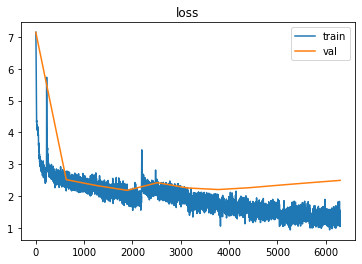

In [100]:
plt.plot(train_x, train_losses, label='train')
plt.plot(val_x, val_losses, label='val')
plt.legend()
plt.title("loss")
plt.show()

In [112]:
test_df = pd.read_csv("dataset_281937_1.txt", encoding="utf-8", delimiter='\t')
test_size = test_df.shape[0]

test_dataset = []

test_question_ids = test_df.iloc[:, 1].values
test_contexts = test_df.iloc[:, 2].values
test_questions = test_df.iloc[:, 3].values

for i in range(test_size):
  context = test_contexts[i]
  question = test_questions[i].strip("?")
  question_id = test_question_ids[i]

  sent, _ = find_closest_sent(context, question, True)

  if sent == None:
    print(context)
    print(question)
    sent = context
    #break

  test_dataset.append({'context': split_text(context),
            'question': split_text(question),
            'question_id': question_id})

padded_test = pad(test_dataset, "test")

Вторая жена (с 7 июня 1850 года) — баронесса Александра фон Бистром (1824—1902), дочь генерал-лейтенанта А. А. Бистрома, внучатая племянница мореплавателя И. Ф. Крузенштерна.[21] Свадьбу играли в гончаровской усадьбе Полотняный Завод, причём таинство венчания было совершено 7/20 июня 1850 года в местном Преображенском храме[22]. Долгое время Пирогову приписывали авторство статьи Идеал женщины , которая представляет собой выборку из переписки Н. И. Пирогова с его второй женой[23]. В 1884 году трудами Александры Антоновны была открыта хирургическая лечебница в Киеве.
Где проходила свадебная церемония
Завиток всегда служил чем-то вроде фирменного клейма — свидетельства о вкусе и мастерстве создателя. Изначально завиток скорее напоминал женскую ступню в туфельке, со временем схожесть становилась всё меньше — узнаваема только пятка , носок изменился до неузнаваемости. Некоторые мастера заменяли завиток скульптурой, как у виол — резной головой льва, например, как это делал Джованни Паоло Мад

In [113]:
with torch.no_grad():
  test_loader = torch.utils.data.DataLoader(padded_test, batch_size=BATCH_SIZE)
  ans = None

  for data in test_loader:
    x = data.to(DEVICE)
    output = model(x.long())
    value, ansx = output.max(dim=2)
    ansx = ansx.cpu().numpy()
    if ans is None:
      ans = ansx
      continue
    ans = np.append(ans, ansx, axis=0)

out_file = open("./out.txt", "w")
for positions, item in zip(ans, test_dataset):
    start, end = positions
    if start > end:
        start, end = end, start
    if end >= len(item['context']):
        start, end = 0, len(item['context']) - 1
    #print(type(item['question_id']))
    #print(type("".join(item['context'][start:end + 1])))
    out_file.write(str(item['question_id']) + "\t" + "".join(item['context'][start:end + 1]) + "\n")

out_file.close()